apm 139.124.66.248_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            8
   Intermediates:            0
   Connections  :            2
   Equations    :            8
   Residuals    :            8
 
 Number of state variables:           1403
 Number of total equations: -         1500
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :            -97
 
 * Warning: DOF <= 0
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This

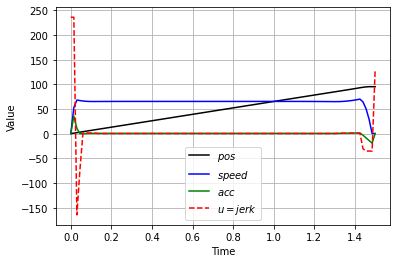

In [1]:
try:
    from gekko import GEKKO
except:
    print("Installing GEKKO...")
    !pip install GEKKO
    from gekko import GEKKO

    # https://stackoverflow.com/questions/61219294/optimal-trajectory-to-minimize-force-issues-with-final-conditions

import numpy as np
import matplotlib.pyplot as plt

m = GEKKO() # initialize gekko
nt = 101
m.time = np.linspace(0,1,nt)

# Constants
xi = 0
xf = 95
vi = 0
vf = 0
ai = 0
af = 0


# Create Variables + plug init values
x = m.Var(value=xi,lb=-1e8,ub=1e8)
v = m.Var(value=vi,lb=-1e8,ub=1e8)
a = m.Var(value=ai,lb=-1e8,ub=1e8)
u = m.Var(fixed_initial=False)

# create end point (so we can do operations/set constraints that only affect the end point)
p = np.zeros(nt) # mark final time point
p[-1] = 1.0
final = m.Param(value=p)


# Variables. I don't really get the difference. But this way works.
# https://gekko.readthedocs.io/en/latest/quick_start.html?highlight=manipulated#variable-types
# FV = fixed variable, only one value over the time horizon
tf = m.FV(value=1.0,lb=0.1,ub=1.50)
tf.STATUS = 1

# MV = manipulated variable / time-dependent, adjustable at all time points in the time horizon
u = m.MV(fixed_initial=False,lb=-1e8,ub=1e8) #lb and ub are super high
u.STATUS = 1


# State vector dynamics
# tau = 1.8
# m.Equation(x.dt()==v*tf)
# m.Equation(v.dt()==a*tf - (v*tf)/tau) # (v*tf)/tau or v/tau ?
# m.Equation(a.dt()==u*tf)
# is the same as:
tau = 1.8
m.Equation(x.dt()/tf ==v)
m.Equation(v.dt()/tf ==a - v/tau) # but removes this ambiguity
m.Equation(a.dt()/tf ==u)

# final time constraints
m.Equation(x*final == xf*final) # or m.Equation((x-xf)*final >= 0)
m.Equation(v*final == vf*final)
m.Equation(a*final == af*final)

# other way of setting final time constraints
# m.Minimize(final*1e5*(x-xf)**2)
# m.Minimize(final*1e5*(v-vf)**2)


# define costs
# movement_cost = m.integral(u**2)*final

ci=0
cost = m.Var(value=ci)
m.Equation(cost.dt()== v**2) # same as above but faster
movement_cost = cost * final

Rwd = 1
time_cost = Rwd-(Rwd/(1+tf))
#time_cost = tf

# Define objective: minimize movement and time costs. Playing with big constants for now, but it seems to work.
m.Obj(1 * movement_cost + 0 * time_cost) # Objective function

# ==> I'll do something like: m.Obj(alpha * movement_cost + beta * time_cost)

# change "sensitivity to time" => get shorter/longer run
# m.Obj(movement_cost + 100000*time_cost) # Objective function
# m.Obj(movement_cost + 200000*time_cost) # Objective function

# solve OCP
m.options.MAX_ITER = 1000
m.options.IMODE = 6 # optimal control mode
m.solve()#disp=False) # solve
print('Final Time: ' + str(tf.value[0]))
m.time = m.time * tf.value[0]

# plot results (pos, speed, acc, jerk)
plt.figure(1) # plot results
plt.grid()
plt.plot(m.time,x.value,'k-',label=r'$pos$')
plt.plot(m.time,v.value,'b-',label=r'$speed$')
plt.plot(m.time,[v/100 for v in a.value],'g-',label=r'$acc$')
plt.plot(m.time,[v/1000 for v in u.value],'r--',label=r'$u=jerk$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


In [2]:
def legend_without_duplicate_labels(ax):
    """Function to avoid having duplicate labels when plotting figures
    Arg:
      ax: ax to use the function on. e.g. legend_without_duplicate_labels(ax00)
    Returns:
      ax.legend() without duplicate labels"""
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

Final Time: 1.2416553068


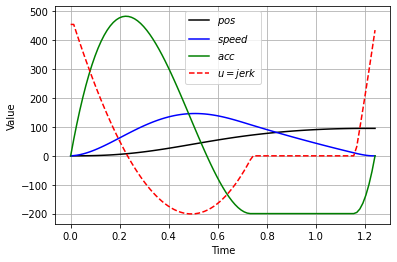

In [3]:
try:
    from gekko import GEKKO
except:
    print("Installing GEKKO...")
    !pip install GEKKO
    from gekko import GEKKO

import numpy as np
import matplotlib.pyplot as plt

m = GEKKO() # initialize gekko
nt = 101
m.time = np.linspace(0,1,nt)

# Constants
xi = 0
xf = 95
vi = 0
vf = 0
ai = 0
af = 0


# Create Variables + plug init values
x = m.Var(value=xi,lb=-1e8,ub=1e8)
v = m.Var(value=vi,lb=-1e8,ub=1e8)
a = m.Var(value=ai,lb=-200,ub=1e8)
u = m.Var(fixed_initial=False)

# create end point (so we can do operations/set constraints that only affect the end point)
p = np.zeros(nt) # mark final time point
p[-1] = 1.0
final = m.Param(value=p)


# Variables. I don't really get the difference. But this way works.
# https://gekko.readthedocs.io/en/latest/quick_start.html?highlight=manipulated#variable-types
# FV = fixed variable, only one value over the time horizon
tf = m.FV(value=1.0,lb=0.1,ub=100)
tf.STATUS = 1

# MV = manipulated variable / time-dependent, adjustable at all time points in the time horizon
u = m.MV(fixed_initial=False,lb=-1e8,ub=1e8) #lb and ub are super high
u.STATUS = 1


# State vector dynamics
# tau = 1.8
# m.Equation(x.dt()==v*tf)
# m.Equation(v.dt()==a*tf - (v*tf)/tau) # (v*tf)/tau or v/tau ?
# m.Equation(a.dt()==u*tf)
# is the same as:
tau = 1.8
#_ = m.if2(a+100, 1, 1.1)

m.Equation(x.dt()/tf ==v)
#m.Equation(v.dt()/tf ==_*a)# - v/tau) # but removes this ambiguity
m.Equation(v.dt()/tf ==a - v/tau)
m.Equation(a.dt()/tf ==u)

# final time constraints
m.Equation(x*final == xf*final) # or m.Equation((x-xf)*final >= 0)
m.Equation(v*final == vf*final)
m.Equation(a*final == af*final)

# other way of setting final time constraints
# m.Minimize(final*1e5*(x-xf)**2)
# m.Minimize(final*1e5*(v-vf)**2)


# define costs
movement_cost = m.integral(u**2)*final

Rwd = 1
time_cost = Rwd-(Rwd/(1+tf))
#time_cost = tf

# Define objective: minimize movement and time costs. Playing with big constants for now, but it seems to work.




m.Obj(1 * movement_cost + 1000000 * time_cost) # Objective function

# ==> I'll do something like: m.Obj(alpha * movement_cost + beta * time_cost)

# change "sensitivity to time" => get shorter/longer run
# m.Obj(movement_cost + 100000*time_cost) # Objective function
# m.Obj(movement_cost + 200000*time_cost) # Objective function

# solve OCP
m.options.MAX_ITER = 10000
m.options.IMODE = 6 # optimal control mode
m.solve(disp=False) # solve
print('Final Time: ' + str(tf.value[0]))
m.time = m.time * tf.value[0]

# plot results (pos, speed, acc, jerk)
plt.figure(1) # plot results
plt.grid()
plt.plot(m.time,x.value,'k-',label=r'$pos$')
plt.plot(m.time,v.value,'b-',label=r'$speed$')
plt.plot(m.time,[v for v in a.value],'g-',label=r'$acc$')
plt.plot(m.time,[v/10 for v in u.value],'r--',label=r'$u=jerk$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


In [4]:
mv_cost = np.sum(np.array(u.value)**2)
time_cost = Rwd-(Rwd/(1+tf.value[0]))

print(np.sum(np.array(cost.value)))
print(mv_cost)
print(time_cost)
#print("val", cost.value)
print(np.sum(np.array(cost.value))/(nt-1))
print(time_cost*(nt-1))
print("gekko objective=",np.sum(np.array(cost.value))/(nt-1) + time_cost*(nt-1))
print(m.options.OBJFCNVAL)

213097.25820742495
276125206.6378182
0.5539010850747093
2130.9725820742497
55.39010850747093
gekko objective= 2186.3626905817205
57944379.834


In [5]:
np.sum(movement_cost.value)

0

/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


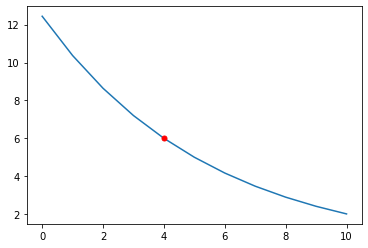

In [6]:
# what if simulation must arrive at intermediate values along the time horizon?
# e.g. maxspeed time
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt
m = GEKKO(remote=False)
m.time = np.linspace(0,10,11)
x = m.Var(np.zeros(11)*6,fixed_initial=False)
m.Equation(5*x.dt() == -x)
pi = np.zeros(11)
pi[4]=1
p = m.Param(pi)

m.Minimize(p*(x-6)**2)
m.options.IMODE = 6
m.solve(disp=False)
plt.plot(m.time, x.value)
plt.plot([4],[6],'ro',MarkerSize=5)
plt.show()

In [22]:
try:
    from gekko import GEKKO
except:
    print("Installing GEKKO...")
    !pip install GEKKO
    from gekko import GEKKO

import numpy as np
import matplotlib.pyplot as plt

def optimal_trajectory(effort, alpha, beta, finaltime, Ltread, vtapis, tau_res, mass, nk):
    m = GEKKO() # initialize gekko
    nt = 101
    m.time = np.linspace(0,1,nt)

    # Constants
    xi, xf = 0.0, Ltread
    vi, vf = 0.0, 0.0
    ai, af = 0.0, 0.0
    ci = 0

    # Create Variables + plug init values
    x = m.Var(value=xi,lb=-1e8,ub=1e8)
    v = m.Var(value=vi,lb=-1e8,ub=1.5)
    a = m.Var(value=ai,lb=-1e8,ub=1e8) #Hard Boundary a = m.Var(value=ai,lb=-200,ub=1e8)
    u = m.Var(fixed_initial=False)
    cost = m.Var(value=ci)
    movement_cost = m.Var(value=ci)
    time_cost = m.Var(value=ci)

    # aalpha = m.Const(value=alpha)
    # bbeta = m.Const(value=beta)

    # create end point (so we can do operations/set constraints that only affect the end point)
    p = np.zeros(nt) # mark final time point
    p[-1] = 1.0
    final = m.Param(value=p)


    # Variables.
    # FV = fixed variable, only one value over the time horizon
    if finaltime != 0.0:
        tf = m.FV(value=1.0,lb=0.1,ub=finaltime)
        tf.STATUS = 1
    else:
        tf = m.FV(value=1.0,lb=0.1,ub=100)
        tf.STATUS = 1

    # MV = manipulated variable / time-dependent, adjustable at all time points in the time horizon
    u = m.MV(fixed_initial=False,lb=-1e8,ub=1e8) #lb and ub are super high
    u.STATUS = 1

    

    # State vector dynamics
    tau = tau_res
    m.Equation(x.dt()/tf ==v)
    m.Equation(v.dt()/tf ==a)# - v/tau)
    m.Equation(a.dt()/tf ==u)
    if effort=='speed': m.Equation(cost== v**2)
    elif effort=='acc': m.Equation(cost== (a- v/tau)**2)
    elif effort=='jerk': m.Equation(cost== u**2)
    elif effort=='mixed': m.Equation(cost== (a- v/tau)*v)

    # final time constraints
    m.Equation(x*final == xf*final) # or m.Equation((x-xf)*final >= 0)
    m.Equation(v*final == vf*final)
    m.Equation(a*final == af*final)


    # define costs
    movement_cost = m.integral(cost) * final
    Rwd = 1
    time_cost = Rwd-(Rwd/(1+tf))

    # Define objective: minimize movement and time costs. 
    if finaltime == 0.0: m.Minimize(beta * time_cost)
    m.Minimize(alpha * movement_cost)


    # solve OCP
    m.options.MAX_ITER = 1000
    m.options.IMODE = 6 # optimal control mode
    m.solve(disp=False) # solve
    print('Final Time: ' + str(tf.value[0]))
    m.time = m.time * tf.value[0]

    return np.array(x.value), np.array(v.value), np.array(a.value), np.array(u.value), np.array(m.time), m.options.OBJFCNVAL

# time_cost = Rwd-(Rwd/(1+tf.value[0]))
# print("gekko objective=",np.sum(np.array(cost.value))/(nt-1) + time_cost*(nt-1))


In [76]:
try:
    from gekko import GEKKO
except:
    print("Installing GEKKO...")
    !pip install GEKKO
    from gekko import GEKKO

import numpy as np
import matplotlib.pyplot as plt

def optimal_trajectory(effort, alpha, beta, finaltime, Ltread, vtapis, tau_res, mass, nk):
    m = GEKKO() # initialize gekko
    nt = 101
    m.time = np.linspace(0,1,nt)

    # Constants
    xi, xf = 0.0, Ltread
    vi, vf = 0.0, 0.0
    ai, af = 0.0, 0.0
    ci = 0

    # Create Variables + plug init values
    x = m.Var(value=xi,lb=-1e8,ub=1e8)
    v = m.Var(value=vi,lb=-1e8,ub=1.5)
    a = m.Var(value=ai,lb=-1e8,ub=1e8) #Hard Boundary a = m.Var(value=ai,lb=-200,ub=1e8)
    u = m.Var(fixed_initial=False)
    cost = m.Var(value=ci)
    movement_cost = m.Var(value=ci)
    time_cost = m.Var(value=ci)

    # aalpha = m.Const(value=alpha)
    # bbeta = m.Const(value=beta)

    # create end point (so we can do operations/set constraints that only affect the end point)
    p = np.zeros(nt) # mark final time point
    p[-1] = 1.0
    final = m.Param(value=p)


    # Variables.
    # FV = fixed variable, only one value over the time horizon
    if finaltime != 0.0:
        tf = m.FV(value=1.0,lb=0.1,ub=finaltime)
        tf.STATUS = 1
    else:
        tf = m.FV(value=1.0,lb=0.1,ub=100)
        tf.STATUS = 1

    # MV = manipulated variable / time-dependent, adjustable at all time points in the time horizon
    u = m.MV(fixed_initial=False,lb=-1e8,ub=1e8) #lb and ub are super high
    u.STATUS = 1

    

    # State vector dynamics
    tau = tau_res
    m.Equation(x.dt()/tf ==v)
    m.Equation(v.dt()/tf ==a)# - v/tau)
    m.Equation(a.dt()/tf ==u)
    if effort=='speed': m.Equation(cost== (v*-vtapis)*2)
    elif effort=='acc': m.Equation(cost == m.if2(a, 20*(a-v/tau)**2, (a-v/tau)**2))#cost== (a- v/tau)**2) #y==m.if3(x-3,6*m.exp(-x)+1,x)
    #elif effort=='jerk': m.Equation(cost== u**2)
    elif effort=='jerk': m.Equation(cost== m.if2(a, 50*u**2, u**2))
    elif effort=='mixed': m.Equation(cost== (a- v/tau)*v)

    # final time constraints
    m.Equation(x*final == xf*final) # or m.Equation((x-xf)*final >= 0)
    m.Equation(v*final == vf*final)
    m.Equation(a*final == af*final)


    # define costs
    movement_cost = m.integral(cost) * final
    Rwd = 1
    time_cost = Rwd-(Rwd/(1+tf))

    # Define objective: minimize movement and time costs. 
    if finaltime == 0.0: m.Minimize(beta * time_cost)
    m.Minimize(alpha * movement_cost)


    # solve OCP
    m.options.MAX_ITER = 100000
    m.options.IMODE = 6 # optimal control mode
    m.solve(disp=False) # solve
    print('Final Time: ' + str(tf.value[0]))
    m.time = m.time * tf.value[0]

    return np.array(x.value), np.array(v.value), np.array(a.value), np.array(u.value), np.array(m.time), m.options.OBJFCNVAL

# time_cost = Rwd-(Rwd/(1+tf.value[0]))
# print("gekko objective=",np.sum(np.array(cost.value))/(nt-1) + time_cost*(nt-1))


Final Time: 1.0402723111
1000


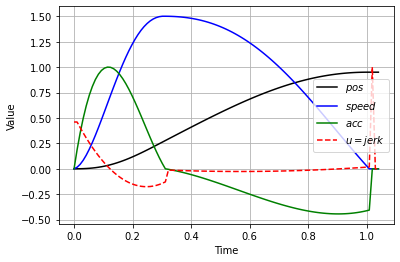

In [77]:
# x, v, a, u, time, cost = optimal_trajectory(effort='jerk', alpha=1, beta=10.2, finaltime=0.0, Ltread=.95, vtapis=0, tau_res=1.8, mass=0, nk=0)
effort='jerk'
alpha=1
beta=1000
finaltime=0.0
Ltread=.95
vtapis=.0
tau_res=1.8
mass=0
nk=0
def o(effort=effort, alpha=alpha, beta=beta, finaltime=finaltime, Ltread=Ltread, vtapis=0, tau_res=1.8, mass=0, nk=0):
    x, v, a, u, time, cost = optimal_trajectory(effort=effort, alpha=alpha, beta=beta, finaltime=finaltime, Ltread=Ltread, vtapis=0, tau_res=1.8, mass=0, nk=0)
    print(beta)
    return x, v, a, u, time, cost

x, v, a, u, time, cost =  o(effort=effort, alpha=alpha, beta=beta, finaltime=finaltime, Ltread=Ltread, vtapis=0, tau_res=1.8, mass=0, nk=0)
# plot results (pos, speed, acc, jerk)
plt.figure(1) # plot results
plt.grid()
plt.plot(time,x,'k-',label=r'$pos$')
plt.plot(time,v,'b-',label=r'$speed$')
plt.plot(time,[v/max(a) for v in a],'g-',label=r'$acc$')
plt.plot(time,[v/max(u) for v in u],'r--',label=r'$u=jerk$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


Final Time: 2.0253875558
1000


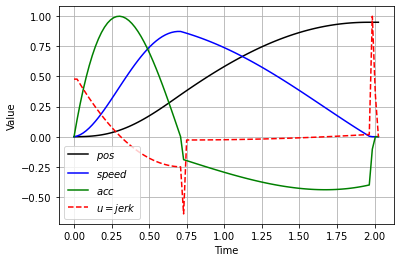

In [78]:
# x, v, a, u, time, cost = optimal_trajectory(effort='jerk', alpha=1, beta=10.2, finaltime=0.0, Ltread=.95, vtapis=0, tau_res=1.8, mass=0, nk=0)
effort='jerk'
alpha=100
beta=1000
finaltime=0.0
Ltread=.95
vtapis=.0
tau_res=1.8
mass=0
nk=0
def o(effort=effort, alpha=alpha, beta=beta, finaltime=finaltime, Ltread=Ltread, vtapis=0, tau_res=1.8, mass=0, nk=0):
    x, v, a, u, time, cost = optimal_trajectory(effort=effort, alpha=alpha, beta=beta, finaltime=finaltime, Ltread=Ltread, vtapis=0, tau_res=1.8, mass=0, nk=0)
    print(beta)
    return x, v, a, u, time, cost

x, v, a, u, time, cost =  o(effort=effort, alpha=alpha, beta=beta, finaltime=finaltime, Ltread=Ltread, vtapis=0, tau_res=1.8, mass=0, nk=0)
# plot results (pos, speed, acc, jerk)
plt.figure(1) # plot results
plt.grid()
plt.plot(time,x,'k-',label=r'$pos$')
plt.plot(time,v,'b-',label=r'$speed$')
plt.plot(time,[v/max(a) for v in a],'g-',label=r'$acc$')
plt.plot(time,[v/max(u) for v in u],'r--',label=r'$u=jerk$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


free time
ic is 0 Dist:  0.3
Final Time: 0.15624340489
Final Time: 0.65884056027
Final Time: 1.5943232986
ic is 1 Dist:  0.63
Final Time: 0.25842591129
Final Time: 0.94536069804
Final Time: 2.0673966622
ic is 2 Dist:  0.95
Final Time: 0.34738590455
Final Time: 1.1637239768
Final Time: 2.3927663735


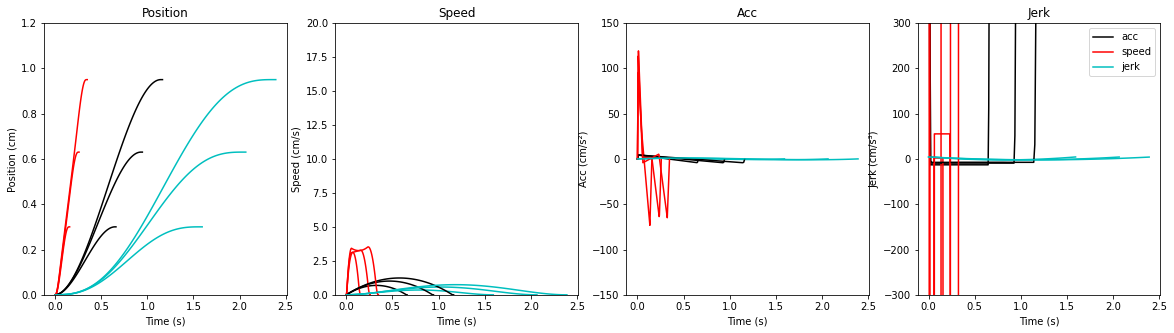

In [9]:
nk=100
print("free time")
Ltread_list = [0.3, 0.63, 0.95]
tf= 0.0 # free time
vtapis=0
tau_res=1.8
mass=0
n_comb = len(Ltread_list)

# speed
xk_vect_speed_heav = np.zeros((nk+1,n_comb))
xdotk_vect_speed_heav = np.zeros((nk+1,n_comb))
acck_vect_speed_heav = np.zeros((nk+1,n_comb))
jerkk_vect_speed_heav = np.zeros((nk+1,n_comb))
time_vect_speed_heav = np.zeros((nk+1,n_comb))
oc_vect_speed_heav = np.zeros((1,n_comb))

# force
xk_vect_force_heav = np.zeros((nk+1,n_comb))
xdotk_vect_force_heav = np.zeros((nk+1,n_comb))
acck_vect_force_heav = np.zeros((nk+1,n_comb))
jerkk_vect_force_heav = np.zeros((nk+1,n_comb))
time_vect_force_heav = np.zeros((nk+1,n_comb))
oc_vect_force_heav = np.zeros((1,n_comb))

# mixed
xk_vect_jerk_heav = np.zeros((nk+1,n_comb))
xdotk_vect_jerk_heav = np.zeros((nk+1,n_comb))
acck_vect_jerk_heav = np.zeros((nk+1,n_comb))
jerkk_vect_jerk_heav = np.zeros((nk+1,n_comb))
time_vect_jerk_heav = np.zeros((nk+1,n_comb))
oc_vect_jerk_heav = np.zeros((1,n_comb))


# Loop: compute optimal trajectory for our 3 Distances [0.3, 0.63, 0.95]
###############################################
###############################################
for ic in range(n_comb):
    Ltread = Ltread_list[ic]
    print("ic is " + str(ic), "Dist: ", Ltread)

    # compute optimal trajectory when cost == speed
    ###############################################
    x, v, a, u, time, cost = optimal_trajectory(effort='speed', alpha=1, beta=1, finaltime=tf, Ltread=Ltread, vtapis=0, tau_res=1.8, mass=0, nk=0)
    xk_vect_speed_heav[:,ic] = x
    xdotk_vect_speed_heav[:,ic] = v
    acck_vect_speed_heav[:,ic] = a
    jerkk_vect_speed_heav[:,ic] = u
    time_vect_speed_heav[:,ic] = time    
    oc_vect_speed_heav[:,ic] = cost     

    # compute optimal trajectory when cost == force
    ###############################################
    x, v, a, u, time, cost = optimal_trajectory(effort='acc', alpha=1, beta=1, finaltime=tf, Ltread=Ltread, vtapis=0, tau_res=1.8, mass=0, nk=0)  
    xk_vect_force_heav[:,ic] = x
    xdotk_vect_force_heav[:,ic] = v
    acck_vect_force_heav[:,ic] = a
    jerkk_vect_force_heav[:,ic] = u
    time_vect_force_heav[:,ic] = time    
    oc_vect_force_heav[:,ic] = cost 

    # compute optimal trajectory when cost == jerk
    ###############################################
    x, v, a, u, time, cost = optimal_trajectory(effort='jerk', alpha=1, beta=1, finaltime=tf, Ltread=Ltread, vtapis=0, tau_res=1.8, mass=0, nk=0)    
    xk_vect_jerk_heav[:,ic] = x
    xdotk_vect_jerk_heav[:,ic] = v
    acck_vect_jerk_heav[:,ic] = a
    jerkk_vect_jerk_heav[:,ic] = u
    time_vect_jerk_heav[:,ic] = time    
    oc_vect_jerk_heav[:,ic] = cost 


# Plot trajectories
###############################################
###############################################  
fig, axs = plt.subplots(ncols = 4, constrained_layout = False, figsize=(20, 5))
for ic in range(len(Ltread_list)):
# for each distance:
    # plot optimal [position][speed][acceleration] for the 3 costs that we computed before
    ## print("ic is " + str(ic), Ltread_list[ic])

    axs[0].set_ylim(0, 1.20)
    axs[0].set_title("Position")
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Position (cm)")
    axs[0].plot(time_vect_force_heav[:,ic],xk_vect_force_heav[:,ic], label = 'acc', color='k')
    axs[0].plot(time_vect_speed_heav[:,ic],xk_vect_speed_heav[:,ic], label = 'speed', color='r')
    axs[0].plot(time_vect_jerk_heav[:,ic],xk_vect_jerk_heav[:,ic], label = 'jerk', color='c')

    axs[1].set_ylim(0, 20)
    axs[1].set_title("Speed")
    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylabel("Speed (cm/s)")
    axs[1].plot(time_vect_force_heav[:,ic],xdotk_vect_force_heav[:,ic], label = 'acc', color='k')
    axs[1].plot(time_vect_speed_heav[:,ic],xdotk_vect_speed_heav[:,ic], label = 'speed', color ='r')
    axs[1].plot(time_vect_jerk_heav[:,ic],xdotk_vect_jerk_heav[:,ic], label = 'jerk', color='c')

    axs[2].set_ylim(-150, 150)
    axs[2].set_title("Acc")
    axs[2].set_xlabel("Time (s)")
    axs[2].set_ylabel("Acc (cm/s²)")
    axs[2].plot(time_vect_force_heav[:,ic],acck_vect_force_heav[:,ic], label = 'acc', color='k')
    axs[2].plot(time_vect_speed_heav[:,ic],acck_vect_speed_heav[:,ic], label = 'speed', color='r')
    axs[2].plot(time_vect_jerk_heav[:,ic],acck_vect_jerk_heav[:,ic], label = 'jerk', color='c')

    axs[3].set_ylim(-300, 300)
    axs[3].set_title("Jerk")
    axs[3].set_xlabel("Time (s)")
    axs[3].set_ylabel("Jerk (cm/s³)")
    axs[3].plot(time_vect_force_heav[:,ic],jerkk_vect_force_heav[:,ic], label = 'acc', color='k')
    axs[3].plot(time_vect_speed_heav[:,ic],jerkk_vect_speed_heav[:,ic], label = 'speed', color='r')
    axs[3].plot(time_vect_jerk_heav[:,ic],jerkk_vect_jerk_heav[:,ic], label = 'jerk', color='c')


# # put legend only in the last plot, use this function to avoid having duplicates (we are in a loop)
legend_without_duplicate_labels(axs[3])



fixed time
ic is 0 Dist:  0.3 duration: 1
Final Time: 0.99999999635
Final Time: 1.0
Final Time: 1.0
ic is 1 Dist:  0.63 duration: 1.3
Final Time: 1.3
Final Time: 1.3
Final Time: 1.3
ic is 2 Dist:  0.95 duration: 1.5
Final Time: 1.5
Final Time: 1.5
Final Time: 1.5


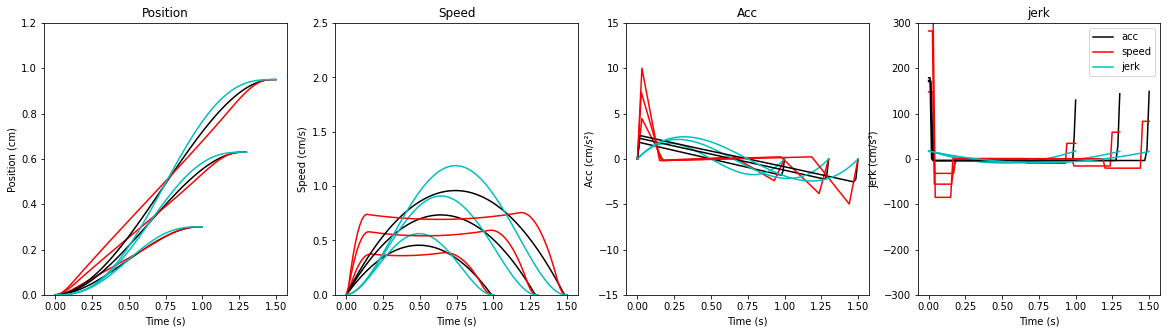

In [10]:
nk=100
print("fixed time")
Ltread_list = [0.3, 0.63, 0.95]
tf_list = [1, 1.3, 1.5] # fixed time, animal data
vtapis=0
tau_res=1.8
mass=0
n_comb = len(Ltread_list)

# speed
xk_vect_speed_heav = np.zeros((nk+1,n_comb))
xdotk_vect_speed_heav = np.zeros((nk+1,n_comb))
acck_vect_speed_heav = np.zeros((nk+1,n_comb))
jerkk_vect_speed_heav = np.zeros((nk+1,n_comb))
time_vect_speed_heav = np.zeros((nk+1,n_comb))
oc_vect_speed_heav = np.zeros((1,n_comb))

# force
xk_vect_force_heav = np.zeros((nk+1,n_comb))
xdotk_vect_force_heav = np.zeros((nk+1,n_comb))
acck_vect_force_heav = np.zeros((nk+1,n_comb))
jerkk_vect_force_heav = np.zeros((nk+1,n_comb))
time_vect_force_heav = np.zeros((nk+1,n_comb))
oc_vect_force_heav = np.zeros((1,n_comb))

# mixed
xk_vect_jerk_heav = np.zeros((nk+1,n_comb))
xdotk_vect_jerk_heav = np.zeros((nk+1,n_comb))
acck_vect_jerk_heav = np.zeros((nk+1,n_comb))
jerkk_vect_jerk_heav = np.zeros((nk+1,n_comb))
time_vect_jerk_heav = np.zeros((nk+1,n_comb))
oc_vect_jerk_heav = np.zeros((1,n_comb))


# Loop: compute optimal trajectory for our 3 Distances [0.3, 0.63, 0.95]
###############################################
###############################################
for ic in range(n_comb):
    Ltread = Ltread_list[ic]
    tf = tf_list[ic]
    print("ic is " + str(ic), "Dist: ", Ltread, "duration:", tf)

    # compute optimal trajectory when cost == speed
    ###############################################
    x, v, a, u, time, cost = optimal_trajectory(effort='speed', alpha=1, beta=1, finaltime=tf, Ltread=Ltread, vtapis=0, tau_res=1.8, mass=0, nk=0)
    xk_vect_speed_heav[:,ic] = x
    xdotk_vect_speed_heav[:,ic] = v
    acck_vect_speed_heav[:,ic] = a
    jerkk_vect_speed_heav[:,ic] = u
    time_vect_speed_heav[:,ic] = time    
    oc_vect_speed_heav[:,ic] = cost     

    # compute optimal trajectory when cost == force
    ###############################################
    x, v, a, u, time, cost = optimal_trajectory(effort='acc', alpha=1, beta=1, finaltime=tf, Ltread=Ltread, vtapis=0, tau_res=1.8, mass=0, nk=0)  
    xk_vect_force_heav[:,ic] = x
    xdotk_vect_force_heav[:,ic] = v
    acck_vect_force_heav[:,ic] = a
    jerkk_vect_force_heav[:,ic] = u
    time_vect_force_heav[:,ic] = time    
    oc_vect_force_heav[:,ic] = cost 

    # compute optimal trajectory when cost == jerk
    ###############################################
    x, v, a, u, time, cost = optimal_trajectory(effort='jerk', alpha=1, beta=1, finaltime=tf, Ltread=Ltread, vtapis=0, tau_res=1.8, mass=0, nk=0)    
    xk_vect_jerk_heav[:,ic] = x
    xdotk_vect_jerk_heav[:,ic] = v
    acck_vect_jerk_heav[:,ic] = a
    jerkk_vect_jerk_heav[:,ic] = u
    time_vect_jerk_heav[:,ic] = time    
    oc_vect_jerk_heav[:,ic] = cost 


# Plot trajectories
###############################################
###############################################  
fig, axs = plt.subplots(ncols = 4, constrained_layout = False, figsize=(20, 5))
for ic in range(len(Ltread_list)):
# for each distance:
    # plot optimal [position][speed][acceleration] for the 3 costs that we computed before
    ## print("ic is " + str(ic), Ltread_list[ic])

    axs[0].set_ylim(0, 1.20)
    axs[0].set_title("Position")
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Position (cm)")
    axs[0].plot(time_vect_force_heav[:,ic],xk_vect_force_heav[:,ic], label = 'acc', color='k')
    axs[0].plot(time_vect_speed_heav[:,ic],xk_vect_speed_heav[:,ic], label = 'speed', color='r')
    axs[0].plot(time_vect_jerk_heav[:,ic],xk_vect_jerk_heav[:,ic], label = 'jerk', color='c')

    axs[1].set_ylim(0, 2.5)
    axs[1].set_title("Speed")
    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylabel("Speed (cm/s)")
    axs[1].plot(time_vect_force_heav[:,ic],xdotk_vect_force_heav[:,ic], label = 'acc', color='k')
    axs[1].plot(time_vect_speed_heav[:,ic],xdotk_vect_speed_heav[:,ic], label = 'speed', color ='r')
    axs[1].plot(time_vect_jerk_heav[:,ic],xdotk_vect_jerk_heav[:,ic], label = 'jerk', color='c')

    axs[2].set_ylim(-15, 15)
    axs[2].set_title("Acc")
    axs[2].set_xlabel("Time (s)")
    axs[2].set_ylabel("Acc (cm/s²)")
    axs[2].plot(time_vect_force_heav[:,ic],acck_vect_force_heav[:,ic], label = 'acc', color='k')
    axs[2].plot(time_vect_speed_heav[:,ic],acck_vect_speed_heav[:,ic], label = 'speed', color='r')
    axs[2].plot(time_vect_jerk_heav[:,ic],acck_vect_jerk_heav[:,ic], label = 'jerk', color='c')

    axs[3].set_ylim(-300, 300)
    axs[3].set_title("jerk")
    axs[3].set_xlabel("Time (s)")
    axs[3].set_ylabel("jerk (cm/s³)")
    axs[3].plot(time_vect_force_heav[:,ic],jerkk_vect_force_heav[:,ic], label = 'acc', color='k')
    axs[3].plot(time_vect_speed_heav[:,ic],jerkk_vect_speed_heav[:,ic], label = 'speed', color='r')
    axs[3].plot(time_vect_jerk_heav[:,ic],jerkk_vect_jerk_heav[:,ic], label = 'jerk', color='c')


# # put legend only in the last plot, use this function to avoid having duplicates (we are in a loop)
legend_without_duplicate_labels(axs[3])



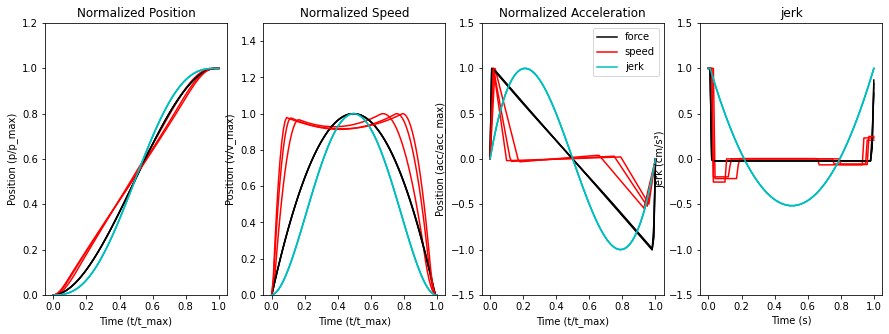

In [11]:

# Normalize by T_max and V_max
##########################################
fig, axs = plt.subplots(ncols = 4, constrained_layout = False, figsize=(15, 5))
for ic in range(n_comb):
    axs[0].set_ylim(0, 1.20)
    axs[0].set_title("Normalized Position")
    axs[0].set_xlabel("Time (t/t_max)")
    axs[0].set_ylabel("Position (p/p_max)")
    axs[0].plot(time_vect_force_heav[:,ic]/max(time_vect_force_heav[:,ic]), xk_vect_force_heav[:,ic]/max(xk_vect_force_heav[:,ic]), label = 'force', color='k')
    axs[0].plot(time_vect_speed_heav[:,ic]/max(time_vect_speed_heav[:,ic]), xk_vect_speed_heav[:,ic]/max(xk_vect_speed_heav[:,ic]), label = 'speed', color='r')
    axs[0].plot(time_vect_jerk_heav[:,ic]/max(time_vect_jerk_heav[:,ic]), xk_vect_jerk_heav[:,ic]/max(xk_vect_jerk_heav[:,ic]), label = 'jerk', color='c')

    axs[1].set_ylim(0, 1.5)
    axs[1].set_title("Normalized Speed")
    axs[1].set_xlabel("Time (t/t_max)")
    axs[1].set_ylabel("Position (v/v_max)")
    axs[1].plot(time_vect_force_heav[:,ic]/max(time_vect_force_heav[:,ic]), xdotk_vect_force_heav[:,ic]/max(xdotk_vect_force_heav[:,ic]), label = 'force', color='k')
    axs[1].plot(time_vect_speed_heav[:,ic]/max(time_vect_speed_heav[:,ic]), xdotk_vect_speed_heav[:,ic]/max(xdotk_vect_speed_heav[:,ic]), label = 'speed', color ='r')
    axs[1].plot(time_vect_jerk_heav[:,ic]/max(time_vect_jerk_heav[:,ic]), xdotk_vect_jerk_heav[:,ic]/max(xdotk_vect_jerk_heav[:,ic]), label = 'jerk', color='c')

    axs[2].set_ylim(-1.50, 1.50)
    axs[2].set_title("Normalized Acceleration")
    axs[2].set_xlabel("Time (t/t_max)")
    axs[2].set_ylabel("Position (acc/acc_max)")
    axs[2].plot(time_vect_force_heav[:,ic]/max(time_vect_force_heav[:,ic]), acck_vect_force_heav[:,ic] / max(acck_vect_force_heav[:,ic]), label = 'force', color='k')
    axs[2].plot(time_vect_speed_heav[:,ic]/max(time_vect_speed_heav[:,ic]), acck_vect_speed_heav[:,ic]/max(acck_vect_speed_heav[:,ic]), label = 'speed', color='r')
    axs[2].plot(time_vect_jerk_heav[:,ic]/max(time_vect_jerk_heav[:,ic]), acck_vect_jerk_heav[:,ic]/max(acck_vect_jerk_heav[:,ic]), label = 'jerk', color='c')

    axs[3].set_ylim(-1.50, 1.50)
    axs[3].set_title("jerk")
    axs[3].set_xlabel("Time (s)")
    axs[3].set_ylabel("jerk (cm/s³)")
    axs[3].plot(time_vect_force_heav[:,ic]/max(time_vect_force_heav[:,ic]),jerkk_vect_force_heav[:,ic]/max(jerkk_vect_force_heav[:,ic]), label = 'acc', color='k')
    axs[3].plot(time_vect_speed_heav[:,ic]/max(time_vect_speed_heav[:,ic]),jerkk_vect_speed_heav[:,ic]/max(jerkk_vect_speed_heav[:,ic]), label = 'speed', color='r')
    axs[3].plot(time_vect_jerk_heav[:,ic]/max(time_vect_jerk_heav[:,ic]),jerkk_vect_jerk_heav[:,ic]/max(jerkk_vect_jerk_heav[:,ic]), label = 'jerk', color='c')

legend_without_duplicate_labels(axs[2])

Final Time: 3.6348116111


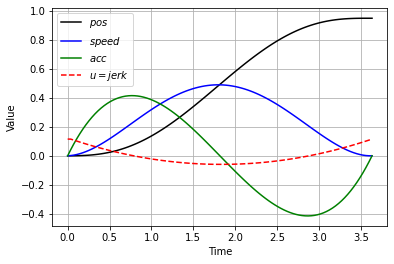

In [12]:
xtest, vtest, atest, utest, timetest, costtest = optimal_trajectory(effort='jerk', alpha=1, beta=.1, finaltime=0.0, Ltread=.95, vtapis=0, tau_res=1.8, mass=0, nk=0)
# plot results (pos, speed, acc, jerk)
plt.figure(1) # plot results
plt.grid()
plt.plot(timetest,xtest,'k-',label=r'$pos$')
plt.plot(timetest,vtest,'b-',label=r'$speed$')
plt.plot(timetest,[v for v in atest],'g-',label=r'$acc$')
plt.plot(timetest,[v/10 for v in utest],'r--',label=r'$u=jerk$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


Final Time: 99.937546284
9.069001324948673 [0.]
Final Time: 99.937546284
9.069001324948673 [1.49011612e-08]
Final Time: 99.937546284
9.069001324948673 [0.14193531]
Final Time: 99.937546284
9.069001324948673 [0.14193533]


/home/david/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Final Time: 99.937546284
9.069001324948673 [0.16862736]
Final Time: 99.937546284
9.069001324948673 [0.16862737]
`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 6, CG iterations: 2, optimality: 8.38e-09, constraint violation: 0.00e+00, execution time: 2.4e+01 s.
0.1686273575312962


/home/david/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Final Time: 3.3023030528


<Figure size 1440x1440 with 0 Axes>

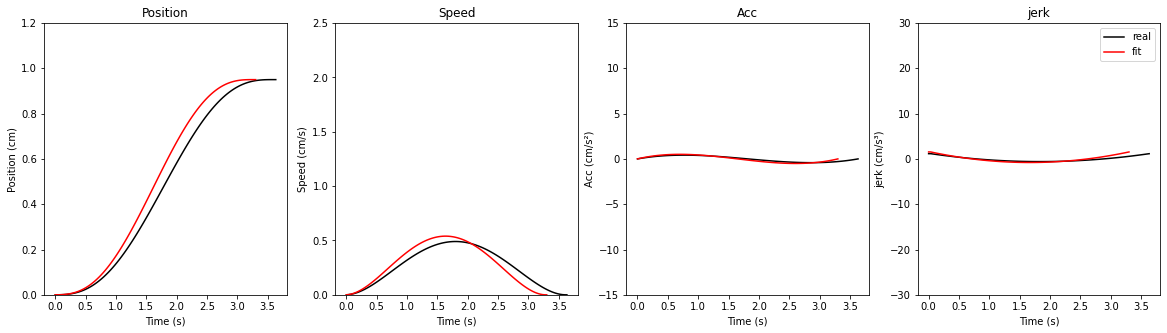

In [13]:
from scipy import optimize

bounds = optimize.Bounds(0,100)

fig = plt.figure(constrained_layout = False, figsize=(20, 20))
gs = fig.add_gridspec(6, 3) #row ,col

real_trajectory = vtest
# xi = real_trajectory[0]
# xf = real_trajectory[-1]
# dist = 1.2#xf-xi
# xdoti = speed_before[rat][0]*0.01
# xdotf = speed_before[rat][-1]*0.01



nk = len(real_trajectory)-1
effort='jerk'
#beta=1
alpha=1
finaltime = 0.0
Ltread = 0.95

def E(beta, effort=effort, alpha=alpha, finaltime=finaltime, Ltread=Ltread, vtapis=0, tau_res=1.8, mass=0, nk=0, real_trajectory=real_trajectory):
    x, v, a, u, t, c = optimal_trajectory(effort=effort, alpha=alpha, beta=int(beta), finaltime=finaltime, Ltread=Ltread, vtapis=0, tau_res=1.8, mass=0, nk=0)    
    #return np.abs((np.max(xk)-np.max(real_trajectory)))
    print(np.sum((v-real_trajectory)**2), beta )
    return np.sum((v-real_trajectory)**2) 
    #return np.sum((beta-20)**2) 


    

res = optimize.minimize(E, x0=np.array([0]), method='trust-constr', bounds=bounds, options={'xtol': 1e-8, 'gtol': 1e-8, 'disp': True}) #1e-1,

b_fit = res.x[0]
print(b_fit)

xfit, vfit, afit, ufit, timefit, costfit = optimal_trajectory(effort='jerk', alpha=alpha, beta=b_fit, finaltime=finaltime, Ltread=Ltread, vtapis=0, tau_res=1.8, mass=0, nk=0)    
fig, axs = plt.subplots(ncols = 4, constrained_layout = False, figsize=(20, 5))


axs[0].set_ylim(0, 1.20)
axs[0].set_title("Position")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Position (cm)")
axs[0].plot(timetest,xtest, label = 'real', color='k')
axs[0].plot(timefit,xfit, label = 'fit', color='r')


axs[1].set_ylim(0, 2.5)
axs[1].set_title("Speed")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Speed (cm/s)")
axs[1].plot(timetest,vtest, label = 'real', color='k')
axs[1].plot(timefit,vfit, label = 'fit', color ='r')

axs[2].set_ylim(-15, 15)
axs[2].set_title("Acc")
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("Acc (cm/s²)")
axs[2].plot(timetest,atest, label = 'real', color='k')
axs[2].plot(timefit,afit, label = 'fit', color='r')


axs[3].set_ylim(-30, 30)
axs[3].set_title("jerk")
axs[3].set_xlabel("Time (s)")
axs[3].set_ylabel("jerk (cm/s³)")
axs[3].plot(timetest,utest, label = 'real', color='k')
axs[3].plot(timefit,ufit, label = 'fit', color='r')



# # put legend only in the last plot, use this function to avoid having duplicates (we are in a loop)
legend_without_duplicate_labels(axs[3])


hidden beta= 8 found beta= 8 tf= 1.6580608858


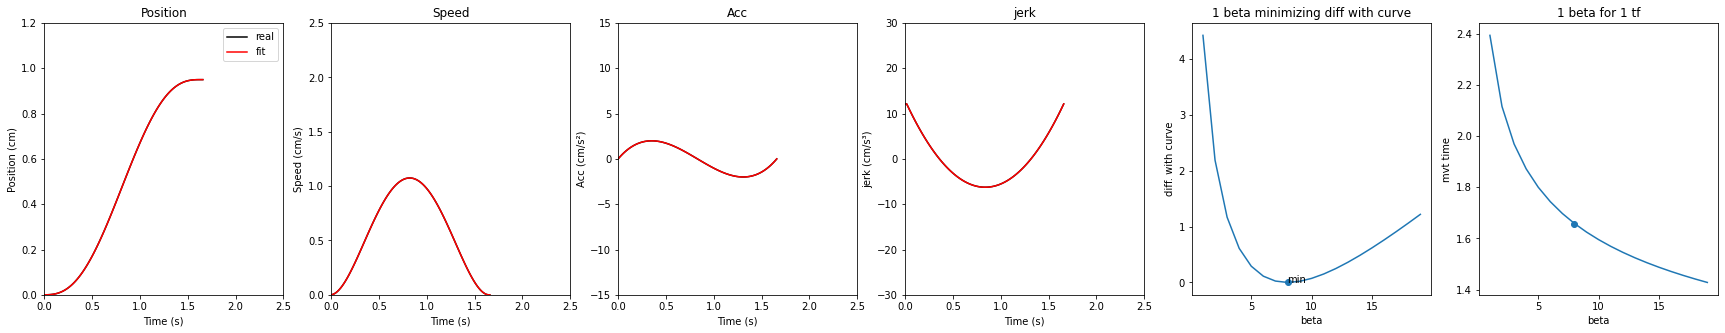

In [14]:
#scipy optimize minimize not working, (problem with beta value//GEKKO???) doing it manually as a proof of concept

#compute optimal traj for set parameters
def optimal_trajectory(effort, alpha, beta, finaltime, Ltread, vtapis, tau_res, mass, nk):
    m = GEKKO() # initialize gekko
    nt = 101
    m.time = np.linspace(0,1,nt)

    # Constants
    xi, xf = 0.0, Ltread
    vi, vf = 0.0, 0.0
    ai, af = 0.0, 0.0
    ci = 0

    # Create Variables + plug init values
    x = m.Var(value=xi,lb=-1e8,ub=1e8)
    v = m.Var(value=vi,lb=-1e8,ub=1e8)
    a = m.Var(value=ai,lb=-1e8,ub=1e8) #Hard Boundary a = m.Var(value=ai,lb=-200,ub=1e8)
    u = m.Var(fixed_initial=False)
    cost = m.Var(value=ci)
    movement_cost = m.Var(value=ci)
    time_cost = m.Var(value=ci)

    # create end point (so we can do operations/set constraints that only affect the end point)
    p = np.zeros(nt) # mark final time point
    p[-1] = 1.0
    final = m.Param(value=p)


    # Variables.
    # FV = fixed variable, only one value over the time horizon
    if finaltime != 0.0:
        tf = m.FV(value=1.0,lb=0.1,ub=finaltime)
        tf.STATUS = 1
    else:
        tf = m.FV(value=1.0,lb=0.1,ub=100)
        tf.STATUS = 1

    # MV = manipulated variable / time-dependent, adjustable at all time points in the time horizon
    u = m.MV(fixed_initial=False,lb=-1e8,ub=1e8) #lb and ub are super high
    u.STATUS = 1

    # State vector dynamics
    tau = tau_res
    m.Equation(x.dt()/tf ==v)
    m.Equation(v.dt()/tf ==a)# - v/tau)
    m.Equation(a.dt()/tf ==u)
    if effort=='speed': m.Equation(cost== v**2)
    elif effort=='acc': m.Equation(cost== (a- v/tau)**2)
    elif effort=='jerk': m.Equation(cost== u**2)

    # final time constraints
    m.Equation(x*final == xf*final) # or m.Equation((x-xf)*final >= 0)
    m.Equation(v*final == vf*final)
    m.Equation(a*final == af*final)

    # define costs
    movement_cost = m.integral(cost) * final
    Rwd = 1
    time_cost = Rwd-(Rwd/(1+tf))

    # Define objective: minimize movement and time costs. 
    if finaltime == 0.0: m.Minimize(beta * time_cost)
    m.Minimize(alpha * movement_cost)

    # solve OCP
    m.options.MAX_ITER = 1000
    m.options.IMODE = 6 # optimal control mode
    m.solve(disp=False) # solve
    m.time = m.time * tf.value[0]

    return np.array(x.value), np.array(v.value), np.array(a.value), np.array(u.value), np.array(m.time), m.options.OBJFCNVAL

#compute diff between experimental and theoretical curve
def E2(beta, effort=effort, alpha=alpha, finaltime=finaltime, Ltread=Ltread, vtapis=0, tau_res=1.8, mass=0, nk=0, real_trajectory=real_trajectory):
    x, v, a, u, t, c = optimal_trajectory(effort=effort, alpha=alpha, beta=int(beta), finaltime=finaltime, Ltread=Ltread, vtapis=0, tau_res=1.8, mass=0, nk=0)    
    #return np.abs((np.max(xk)-np.max(real_trajectory)))
    return np.sum((v-real_trajectory)**2), t

#create a trajectory for a random beta
betarand = np.random.randint(1,20)
xtest, vtest, atest, utest, timetest, costtest = optimal_trajectory(effort='jerk', alpha=1, beta=betarand, finaltime=0.0, Ltread=.95, vtapis=0, tau_res=1.8, mass=0, nk=0)

#try to recover this random beta, compute difference between random curve and curve with beta from 0 to 10. 
r=[]
b=[]
t=[]
for i in range(1, 20):
    res, tt = E2(i, alpha=alpha, effort=effort, finaltime=finaltime, Ltread=.95, vtapis=0, tau_res=1.8, mass=0, nk=0, real_trajectory=vtest)
    r.append(res)
    b.append(i)
    t.append(tt[-1])




xfit, vfit, afit, ufit, timefit, costfit = optimal_trajectory(effort='jerk', alpha=alpha, beta=b[np.argmin(r)], finaltime=finaltime, Ltread=Ltread, vtapis=0, tau_res=1.8, mass=0, nk=0)    
fig, axs = plt.subplots(ncols = 6, constrained_layout = False, figsize=(30, 5))


axs[0].set_ylim(0, 1.20)
axs[0].set_xlim(0, 2.50)
axs[0].set_title("Position")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Position (cm)")
axs[0].plot(timetest,xtest, label = 'real', color='k')
axs[0].plot(timefit,xfit, label = 'fit', color='r')
axs[0].legend()


axs[1].set_ylim(0, 2.5)
axs[1].set_xlim(0, 2.50)
axs[1].set_title("Speed")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Speed (cm/s)")
axs[1].plot(timetest,vtest, label = 'real', color='k')
axs[1].plot(timefit,vfit, label = 'fit', color ='r')

axs[2].set_ylim(-15, 15)
axs[2].set_xlim(0, 2.50)
axs[2].set_title("Acc")
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("Acc (cm/s²)")
axs[2].plot(timetest,atest, label = 'real', color='k')
axs[2].plot(timefit,afit, label = 'fit', color='r')


axs[3].set_ylim(-30, 30)
axs[3].set_xlim(0, 2.50)
axs[3].set_title("jerk")
axs[3].set_xlabel("Time (s)")
axs[3].set_ylabel("jerk (cm/s³)")
axs[3].plot(timetest,utest, label = 'real', color='k')
axs[3].plot(timefit,ufit, label = 'fit', color='r')

axs[4].set_title("1 beta minimizing diff with curve")
axs[4].set_xlabel("beta")
axs[4].set_ylabel("diff. with curve")
axs[4].plot(b, r)
axs[4].scatter(b[np.argmin(r)], r[np.argmin(r)])
axs[4].annotate("min", (b[np.argmin(r)], r[np.argmin(r)]))

axs[5].set_title("1 beta for 1 tf")
axs[5].set_xlabel("beta")
axs[5].set_ylabel("mvt time")
axs[5].plot(b, t)
axs[5].scatter(b[np.argmin(r)], t[np.argmin(r)])


print("hidden beta=", betarand, "found beta=", b[np.argmin(r)], "tf=", timefit[-1])

